## 1.資料前處理

In [1]:
import numpy as np 
A = []
f = open('att48_xy.txt')        #開啟檔案`,這邊以att48為範例，資料格式為每個城市的經緯度座標，eg 1 120 50
lines = f.readlines()           #把全部資料檔案讀到一個列表lines中
ind = 0
for line in lines:              #把lines中的資料逐行讀取出來
    list = line.strip('\n').split(' ')   #處理逐行資料：strip表示把頭尾的'\n'去掉，split表示以空格來分割行資料，然後把處理後的行資料返回到list列表中
    list = [i for i in list if(len(str(i))!=0)]
    A.append([int(list[0]), int(list[1])])          #把處理後的資料放到方陣A中。
    ind += 1
print(A)

[[6734, 1453], [2233, 10], [5530, 1424], [401, 841], [3082, 1644], [7608, 4458], [7573, 3716], [7265, 1268], [6898, 1885], [1112, 2049], [5468, 2606], [5989, 2873], [4706, 2674], [4612, 2035], [6347, 2683], [6107, 669], [7611, 5184], [7462, 3590], [7732, 4723], [5900, 3561], [4483, 3369], [6101, 1110], [5199, 2182], [1633, 2809], [4307, 2322], [675, 1006], [7555, 4819], [7541, 3981], [3177, 756], [7352, 4506], [7545, 2801], [3245, 3305], [6426, 3173], [4608, 1198], [23, 2216], [7248, 3779], [7762, 4595], [7392, 2244], [3484, 2829], [6271, 2135], [4985, 140], [1916, 1569], [7280, 4899], [7509, 3239], [10, 2676], [6807, 2993], [5185, 3258], [3023, 1942]]


In [2]:
A[0]

[6734, 1453]

## 2.Simulated Annealing algorithm 主程式

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import shutil
import time

#產生所需之資料格式
def create_data(N):
    calDistance = lambda x, y: np.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2) #calculate distance between 2 locations
    points = A                                                                  #our dataset [x_cord, y_cord]
    Mat = np.zeros((N, N))                                                      #initialize
    for i in range(N):
        for j in range(i + 1, N):
            dv = calDistance(points[i], points[j])
            Mat[i][j], Mat[j][i] = dv, dv
    return points, Mat                                                          #create a matrix with dist b/n 2 locs

#計算可行解的值
def calpathValue(path):
    global Mat
    temp = Mat[0][path[0]]                                                      #choose one path and accumulate dists
    for i in range(len(path) - 1):                                              
        temp += Mat[path[i]][path[i + 1]]                                       #accumulation
    temp += Mat[path[-1]][0]                                                    #dist from end to init
    return temp

#產生初始解
def initial():
    global N
    init = np.arange(1, N)
    random.shuffle(init)                                                        #打亂順序產生初始解
    packValue = calpathValue(init)                                              #計算解的品質
    return init, packValue

#劃出TSP路線圖
def draw(path, pv):
    global points, N
    plt.cla()                     #clear axis
    plt.title('best value of Att48 = %.4f' % pv)
    xs = [p[0] for p in points]
    ys = [p[1] for p in points]
    plt.scatter(xs, ys, color='b')
    xs = np.array(xs)
    ys = np.array(ys)
    plt.plot(xs[[0, path[0]]], ys[[0, path[0]]], color='r')
    for i in range(N - 2):
        plt.plot(xs[[path[i], path[i + 1]]], ys[[path[i], path[i + 1]]], color='r')
    plt.plot(xs[[path[N - 2], 0]], ys[[path[N - 2], 0]], color='r')
    plt.scatter(xs[0], ys[0], color='k', linewidth=10)
    for i, p in enumerate(points):
        plt.text(*p, '%d' % i)




## 3.模擬過程

CPU Time 25.755477905273438
SA near-optimal solution length: 35866.68073376177
Best route map: 0-->7-->15-->21-->2-->33-->22-->10-->11-->14-->39-->8-->37-->30-->43-->17-->6-->27-->5-->36-->18-->26-->16-->42-->29-->35-->45-->32-->19-->46-->20-->12-->13-->24-->38-->31-->23-->9-->44-->34-->3-->25-->41-->47-->4-->28-->1-->40-->

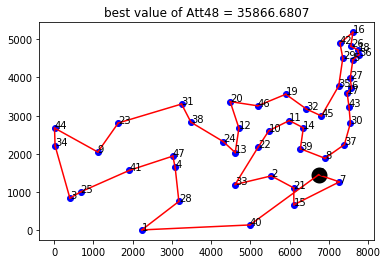

In [5]:
if __name__ == '__main__':
    '''
    優化方向
    1. 降溫方式 T *= alpha  -->>  T / (1 + beta * T)
    2. 鄰近解的搜尋方式 
    3. prob of acceptance np.exp((value - tempValue) / (K * T))  -->>  np.exp((value - tempValue) / (value * T))
    4. 設計[起始溫度,最低溫度] = [0,1] 在該區間內持續迭代，當低於最低溫後，跳出迴圈，rest T & limitedT
    '''
    N = 48                        # 城市數量
    points, Mat = create_data(N)  # 餵入資料產生對應之格式
    T = 50000                      # 起始溫度
    alpha = 0.975                 # T_{k+1} = alpha * T_k方式更新溫度
    limitedT = 1.                 # 最小值的T
    iterTime = 1000               # 每個溫度下迭代的次數
    K = 0.98                       # 係數K
    p = 0                         # 接受機率
    
    path, value = initial()
    tempPath, tempValue = [], 0
    global_Best = value           # 畫圖
    start_time = time.time()
    while T > limitedT:
        #print(T)
        for i in range(iterTime):
            tempPath = path.copy()
            tx = random.randint(0, N - 2)
            ty = random.randint(0, N - 2)
            if tx != ty:
                tempPath[tx], tempPath[ty] = tempPath[ty], tempPath[tx]  #隨機找兩個插入點，若不相同則交換位置
                tempValue = calpathValue(tempPath)
                if tempValue <= value:                                   #新解優於當下最佳解，則更新最佳解
                    path = tempPath.copy()
                    value = tempValue.copy()
                else:
                    p = np.exp((value - tempValue) / (K * T))            #新解未優於最佳解，計算接受機率
                    if random.random() < p:
                        path = tempPath.copy()
                        value = tempValue.copy()
        if value < global_Best:
            global_Best = value
            draw(path, value)
        T *= alpha                                                       #溫度更新方式
    exec_time =  time.time() - start_time
    print('CPU Time', exec_time)
    print('SA near-optimal solution length:', value)
    print('Best route map:', 0, end='-->')
    for i in path:
        print(i, end='-->')


CPU Time 75.1233320236206
SA near-optimal solution length: 77297.2681682001
Best route map: 0-->17-->6-->35-->41-->23-->31-->38-->43-->42-->32-->14-->46-->20-->34-->25-->44-->9-->3-->1-->21-->15-->12-->11-->8-->27-->16-->36-->29-->26-->10-->13-->22-->24-->39-->7-->37-->5-->18-->30-->45-->19-->2-->40-->33-->47-->28-->4-->

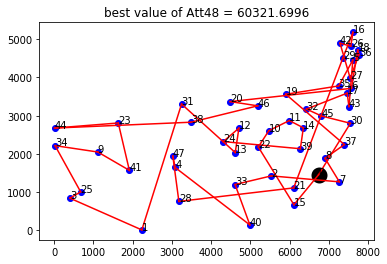

In [5]:
if __name__ == '__main__':
    '''
    優化方向
    1. 降溫方式 T *= alpha  -->>  T / (1 + beta * T)
    2. 鄰近解的搜尋方式 
    3. prob of acceptance np.exp((value - tempValue) / (K * T))  -->>  np.exp((value - tempValue) / (value * T))
    4. 設計[起始溫度,最低溫度] = [0,1] 在該區間內持續迭代，當低於最低溫後，跳出迴圈，rest T & limitedT
    '''
    N = 48                        # 城市數量
    points, Mat = create_data(N)  # 餵入資料產生對應之格式
    T = 1                      # 起始溫度
    beta = 0.1                 # T_{k+1} = alpha * T_k方式更新溫度
    limitedT = 0.01                 # 最小值的T
    iterTime = 1000               # 每個溫度下迭代的次數
    K = 0.8                       # 係數K
    p = 0                         # 接受機率
    
    tempPath, tempValue = [], 0
    path, value = initial()
    
    global_Best = value           # 畫圖
    start_time = time.time()
    for i in range(iterTime):
        #print(T)
        
        while T > limitedT:
            tempPath = path.copy()
            tx = random.randint(0, N - 2)
            ty = random.randint(0, N - 2)
            if tx != ty:
                tempPath[tx], tempPath[ty] = tempPath[ty], tempPath[tx]  #隨機找兩個插入點，若不相同則交換位置
                tempValue = calpathValue(tempPath)
                if tempValue <= value:                                   #新解優於當下最佳解，則更新最佳解
                    path = tempPath.copy()
                    value = tempValue.copy()
                else:
                    p = np.exp((value - tempValue) / (value * T))            #新解未優於最佳解，計算接受機率
                    if random.random() < p:
                        path = tempPath.copy()
                        value = tempValue.copy()
                    T = T / (1 + beta * T) 
        if value < global_Best:
            global_Best = value
            draw(path, value)
        T = 1

    exec_time =  time.time() - start_time
    print('CPU Time', exec_time)
    print('SA near-optimal solution length:', value)
    print('Best route map:', 0, end='-->')
    for i in path:
        print(i, end='-->')
